Third retry of VAE with conv1d (rewritten from scratch)

still pretty weird

In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

In [7]:
# Load data
window_size = 600
data_buf = np.load('data.npy')
index_buf = np.load('index.npy')
data = data_buf[53, :1055000]
index = index_buf[index_buf < 1055000].astype(int) 
print(data.shape)
print(index)

(1055000,)
[  25351   32967   65124  110605  110614  139796  139803  179850  179858
  220048  231137  245534  270780  270789  309584  429010  477457  483625
  483633  520625  525407  525415  536316  536324  565340  689253  713584
  720463  725368  807271  852387  923113  972713  985866 1009480 1046297
 1052564]


TODO: mix non cs and cs in the dataset

In [3]:
class NeuroDataset(Dataset):
    def __init__(self, data, indices, window_size):
        self.data = data
        self.indices = indices
        self.window_size = window_size
    
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx):
        center = self.indices[idx]
        start = max(center - self.window_size // 2, 0)
        end = min(center + self.window_size // 2, len(self.data))
        sample = self.data[start:end]
        if len(sample) < self.window_size:
            sample = np.pad(sample, (0, self.window_size - len(sample)), 'constant')
        return torch.tensor(sample, dtype=torch.float32)

dataset = NeuroDataset(data, index, window_size)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

In [4]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=3, stride=2, padding=1),  # 输出:[16, 300]
            nn.ReLU(),
            nn.Conv1d(16, 32, kernel_size=3, stride=2, padding=1),  # 输出:[32, 150]
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=3, stride=2, padding=1),  # 输出:[64, 75]
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * 75, 100),
            nn.Linear(100, 20) 
        )
        self.decoder = nn.Sequential(
            nn.Linear(10, 100),
            nn.Linear(100, 64 * 75),
            nn.ReLU(),
            nn.Unflatten(1, (64, 75)),
            nn.ConvTranspose1d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
            # nn.Tanh()
        )
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x = x.view(-1, 1, 600)  # Reshape to [batch_size, channels, window_size]
        encoded = self.encoder(x)
        mu, log_var = encoded[:, :10], encoded[:, 10:]
        z = self.reparameterize(mu, log_var)
        return self.decoder(z), mu, log_var
    
def loss_function(recon_x, x, mu, log_var):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

# def loss_function(recon_x, x, mu, log_var):
#     # use MSE to replace BCE
#     MSE = nn.functional.mse_loss(recon_x, x, reduction='sum')
#     KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
#     return MSE + KLD

def train(model, dataloader, optimizer):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(dataloader):
        optimizer.zero_grad()
        recon_batch, mu, log_var = model(data)
        recon_batch = recon_batch.squeeze(1)
        # recon_batch = recon_batch.squeeze()
        # data = data.view(data.size(0), -1)
        loss = loss_function(recon_batch, data, mu, log_var)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    return train_loss

In [5]:
model = VAE()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 10

for epoch in range(num_epochs):
    loss = train(model, dataloader, optimizer)
    print(f'Epoch {epoch+1}, Loss: {loss}')

Epoch 1, Loss: -1239966.3853149414
Epoch 2, Loss: -11969767.34375
Epoch 3, Loss: -16141137.90625
Epoch 4, Loss: -17489063.625
Epoch 5, Loss: -17048272.75
Epoch 6, Loss: -17170619.84375
Epoch 7, Loss: -16940601.78125
Epoch 8, Loss: -17694387.9375
Epoch 9, Loss: -18818802.171875
Epoch 10, Loss: -21997705.0


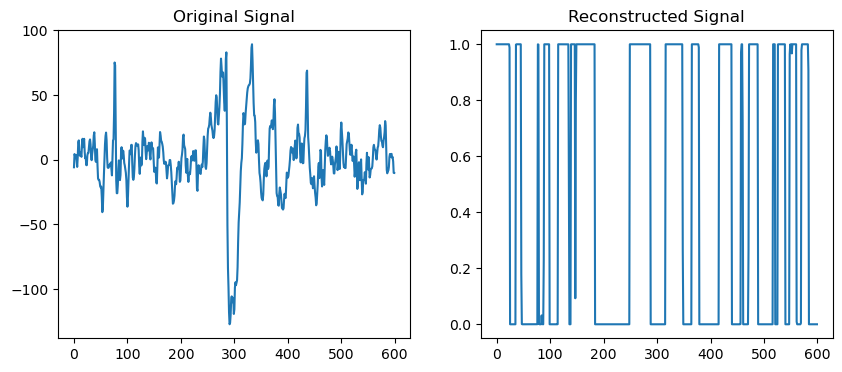

In [6]:
import matplotlib.pyplot as plt

def plot_reconstructions(model, dataloader, n=1):
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(dataloader):
            if i >= n: break
            recon, _, _ = model(data)
            data = data[0].squeeze()
            recon = recon[0].squeeze()
            plt.figure(figsize=(10, 4))
            plt.subplot(1, 2, 1)
            plt.plot(data.cpu().numpy())
            plt.title("Original Signal")
            plt.subplot(1, 2, 2)
            plt.plot(recon.cpu().numpy())
            plt.title("Reconstructed Signal")
            plt.show()

plot_reconstructions(model, dataloader)

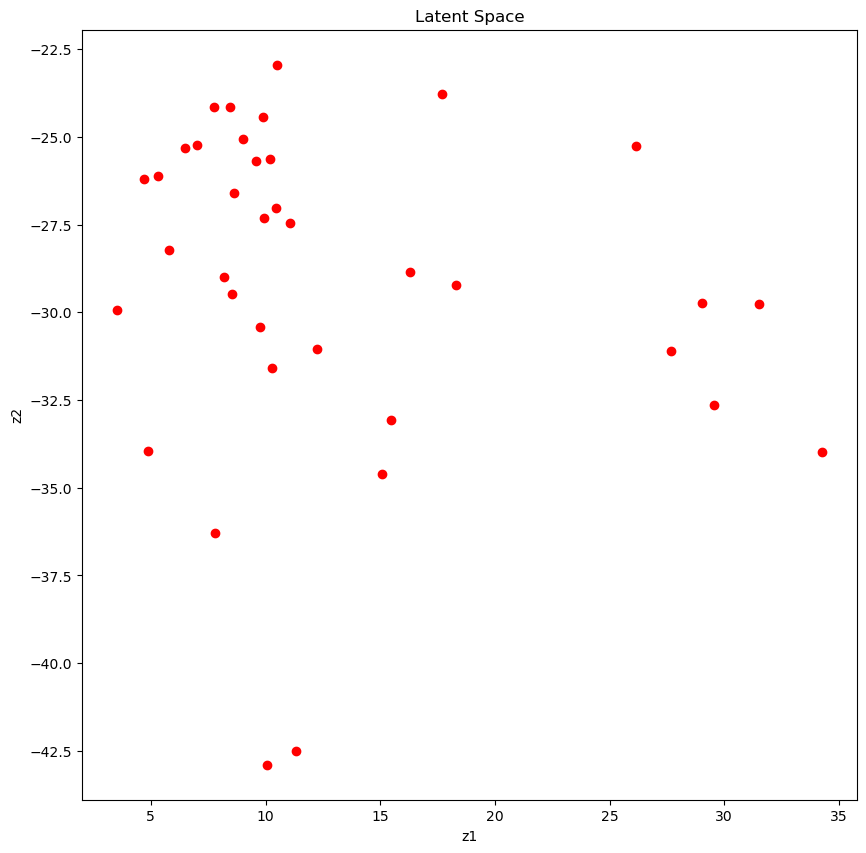

In [11]:
# def visualize_latent_space(model, dataloader):
#     model.eval()
#     with torch.no_grad():
#         plt.figure(figsize=(10, 10))
#         for i, data in enumerate(dataloader):
#             recon, mu, _ = model(data)
#             plt.scatter(mu[:, 0], mu[:, 1], c='r')
#             plt.title("Latent Space")
#             plt.xlabel("z1")
#             plt.ylabel("z2")
#         plt.show()    
            
# visualize_latent_space(model, dataloader)